Copied main code from https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d - includes jupyter notbeook

Importing relevant packages -- pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np 
import gzip
import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)

1.9.1


Checking whether GPU is available using Pytorch

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
4


## Import The Data

### Import Labels
Reading in array with training labels using labels from MNIST directly 

https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python

In [4]:
train_labels = np.empty(60000) #we know there are 60000 training images 
test_labels = np.empty(10000) #we know there are 10000 testing images 

In [5]:
print(train_labels.shape)
print(test_labels.shape)

(60000,)
(10000,)


In [6]:
train_labels[0]

4.0474e-320

In [7]:
f = gzip.open('labels/train-labels-idx1-ubyte.gz','r')
f.read(8)
for i in range(0,len(train_labels)):   
    buf = f.read(1)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    train_labels[i] = labels[0]

In [8]:
f = gzip.open('labels/t10k-labels-idx1-ubyte.gz','r')
f.read(8)
for i in range(0,len(test_labels)):   
    buf = f.read(1)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    test_labels[i] = labels[0]

In [30]:
train_labels = train_labels.astype(np.long)
test_labels = test_labels.astype(np.long)

In [31]:
print(train_labels)
print(test_labels)

[5 0 4 ... 5 6 8]
[7 2 1 ... 4 5 6]


In [32]:
len(train_labels)

60000

### Custom Dataset
Might need to transform data using the `transforms` module

Created own Dataset class for illusion images specifically - Pytorch uses DataLoaders and Datasets to organize data 

assuming images are in directory `img_dir` and labels are pre-processed and read into array `labels_arr`

Code from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [33]:
import pandas as pd
from torch.utils.data import Dataset
from torchvision.io import read_image
import os

class IllusionDataset(Dataset): 
    def __init__(self, labels_arr, img_dir, transform=None, target_transform=None):
      self.img_labels = labels_arr #labels are in a numpy array 
      self.img_dir = img_dir
      self.transform = transform
      self.target_transform = target_transform 

    def __len__(self): 
      return len(self.img_labels)
      #returns hum. instances in dataset 
    
    #loads and returns sample from dataset at given index
    def __getitem__(self, idx): #images are labeled from 0 to length(labels) 
      img_path = os.path.join(self.img_dir, str(idx)+".jpg") #finds the location of given image based on index (which is image name)
      image = torch.from_numpy(read_image(img_path).numpy().astype(np.float32)) #converts to tensor 
        
      label = self.img_labels[idx] #finds label from array of labels  
      if self.transform: 
        image = self.transform(image) #apply transformations 
      if self.target_transform: 
        label = self.target_transform(label)
      return image, label #returns tuple of image and label 

In [34]:
train_path = "illusionmnist"
test_path = "illusionmnisttest"

train_dataset = IllusionDataset(train_labels, train_path)
test_dataset = IllusionDataset(test_labels, test_path)

In [35]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 128, 128])
Labels batch shape: torch.Size([64])


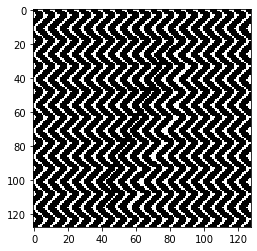

Label: 1


In [36]:
# Display image and label.
train_features, train_labelss = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labelss.size()}")
img = train_features[3].squeeze()
label = train_labelss[3]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [37]:
img

tensor([[  1.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   1.,  ...,   0.,   3.,   0.],
        [255.,   2.,   0.,  ..., 255.,   0.,   3.],
        ...,
        [  0.,   1.,   0.,  ..., 254.,   2.,   0.],
        [  2.,   0.,   2.,  ...,   3.,   0.,   1.],
        [  0.,   0.,   0.,  ...,   1.,   0.,   0.]])

## Exploring the Data **from original notebook


Let's check what the train and test dataset contains. I will use `matplotlib` to print out some of the images from our dataset. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


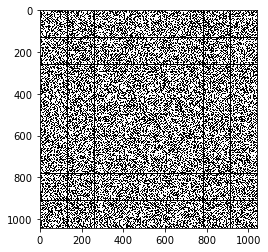

In [38]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

Let's check the dimensions of a batch.

In [39]:
for images, labels in train_dataloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([64, 1, 128, 128])
Image label dimensions: torch.Size([64])


## The Model **from original notebook

Now using the classical deep learning framework pipeline, let's build the 1 convolutional layer model. 

Here are a few notes for those who are beginning with PyTorch:
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have a convolutional layer denoted by `nn.Conv2d(...)`. We are dealing with an image dataset that is in a grayscale so we only need one channel going in, hence `in_channels=1`. We hope to get a nice representation of this layer, so we use `out_channels=32`. Kernel size is 3, and for the rest of parameters we use the default values which you can find [here](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#conv2d). 
- We use 2 back to back dense layers or what we refer to as linear transformations to the incoming data. Notice for `d1` I have a dimension which looks like it came out of nowhere. 128 represents the size we want as output and the (`26*26*32`) represents the dimension of the incoming data. If you would like to find out how to calculate those numbers refer to the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html?highlight=linear#conv2d). In short, the convolutional layer transforms the input data into a specific dimension that has to be considered in the linear layer. The same applies for the second linear transformation (`d2`) where the dimension of the output of the previous linear layer was added as `in_features=128`, and `10` is just the size of the output which also corresponds to the number of classes.
- After each one of those layers, we also apply an activation function such as `ReLU`. For prediction purposes, we then apply a `softmax` layer to the last transformation and return the output of that.  

In [55]:
class Model1(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        #128x128x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(126 * 126 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [80]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        #128x128x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.max1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.max2 = nn.MaxPool2d(kernel_size=3, stride=1) 
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 128, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.max1(x)
        
        x = self.conv2(x)
        x = F.relu(x) 
        
        x = self.max2(x)
        
        x = self.conv3(x) 
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [81]:
## test the model with 1 batch
model = MyModel()
for images, labels in train_dataloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([64, 1, 128, 128])
torch.Size([64, 10])


## Training the Model **from original notebook
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model. 

In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [88]:
learning_rate = 0.0015
num_epochs = 10
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
?torch.cuda

In [89]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

Now it's time for training.

In [90]:
BATCH_SIZE = 64

In [91]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(train_dataloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))        

Epoch: 0 | Loss: 2.3649 | Train Accuracy: 9.88
Epoch: 1 | Loss: 2.3649 | Train Accuracy: 9.88
Epoch: 2 | Loss: 2.3650 | Train Accuracy: 9.88
Epoch: 3 | Loss: 2.3649 | Train Accuracy: 9.88
Epoch: 4 | Loss: 2.3649 | Train Accuracy: 9.88
Epoch: 5 | Loss: 2.3650 | Train Accuracy: 9.88
Epoch: 6 | Loss: 2.3650 | Train Accuracy: 9.88
Epoch: 7 | Loss: 2.3649 | Train Accuracy: 9.88
Epoch: 8 | Loss: 2.3650 | Train Accuracy: 9.88
Epoch: 9 | Loss: 2.3649 | Train Accuracy: 9.88


We can also compute accuracy on the testing dataset to see how well the model performs on the image classificaiton task. As you can see below, our basic CNN model is performing very well on the MNIST classification task.

In [92]:
test_acc = 0.0
for i, (images, labels) in enumerate(test_dataloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 9.82


# Testing on Single Illusion Image

In [ ]:
import cv2
import numpy as np
img = cv2.imread('four.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
from PIL import Image
from torch.autograd import Variable

imsize = 28
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
#Resize: https://www.projectpro.io/recipes/crop-and-resize-image-pytorch

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

image = image_loader('four_norm.png')

#source: https://discuss.pytorch.org/t/how-to-classify-single-image-using-loaded-net/1411/3
#http://seba1511.net/tutorials/beginner/examples_autograd/two_layer_net_autograd.html 

result = model(image)
print(result) 
predict = torch.argmax(result[0])
print("value predicted:", torch.Tensor.item(predict))

tensor([[6.7594e-18, 8.8568e-14, 1.4284e-11, 1.7360e-12, 1.0000e+00, 2.7135e-15,
         1.2092e-14, 6.5897e-13, 1.6659e-14, 2.1681e-11]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
value predicted: 4


In [ ]:
image2 = image_loader('four.png')

result2 = model(image2)
print(result2) 
predict2 = torch.argmax(result2[0])
print("value predicted:", torch.Tensor.item(predict2))

tensor([[0.0963, 0.1242, 0.0915, 0.0934, 0.1009, 0.1106, 0.0970, 0.1023, 0.0905,
         0.0933]], device='cuda:0', grad_fn=<SoftmaxBackward>)
value predicted: 1


## References **original notebook
- [Building RNNs is Fun with PyTorch and Google Colab](https://colab.research.google.com/drive/1NVuWLZ0cuXPAtwV4Fs2KZ2MNla0dBUas)
- [CNN Basics with PyTorch by Sebastian Raschka](https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-basic.ipynb)
- [Tensorflow 2.0 Quickstart for experts](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb#scrollTo=DUNzJc4jTj6G) 